In [1]:
import numpy as np
import pandas as pd
from glob import glob
import proplot as plot
import cartopy.crs as ccrs
from satpy.scene import Scene

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
# set data dir
s5p_dir = '../data/tropomi/'
fy4a_dir = '../data/fy4a/'
sonde_dir = '../data/ozonesondes/data/'

In [4]:
# set data
f_s5p_1 = s5p_dir + 'S5P_TEST_L2__NO2____20190725*'
f_s5p_2 = s5p_dir + 'S5P_TEST_L2__NO2____20200901*'

f_fy4a_1 = fy4a_dir + 'FY4A-_AGRI--_N_*NOM_201907250700*0500M_V0001.HDF'
f_fy4a_2 = fy4a_dir + 'FY4A-_AGRI--_N_*NOM_202009010638*0500M_V0001.HDF'

sonde_1 = sonde_dir + '20190725/20190723_0529.csv'
sonde_2 = sonde_dir + '20190725/20190725_0634.csv'
sonde_3 = sonde_dir + '20200901/20200831_234453.csv'
sonde_4 = sonde_dir + '20200901/20200901_054434.csv'

In [5]:
# set plot region
extend = [118, 120, 31.2, 32.8]
lon_d = 0.5; lat_d = 0.5

In [6]:
def load_s5p(f_s5p):
    '''load s5p data'''
    scn = Scene(glob(f_s5p), reader='tropomi_l2')
    
    # useful vars
    vnames = ['latitude', 'longitude',
              'assembled_lat_bounds', 'assembled_lon_bounds',
              'cloud_radiance_fraction_nitrogendioxide_window',
              'time_utc']

    # load directly by satpy
    scn.load(vnames)

    # get vars
    lat = scn[vnames[0]]
    lon = scn[vnames[1]]
    lat_bnd = scn[vnames[2]]
    lon_bnd = scn[vnames[3]]
    crf = scn[vnames[4]]
    t   = scn[vnames[5]]

    return lat, lon, lat_bnd, lon_bnd, crf, t

In [7]:
def load_fy4a(f_fy4a, extend):
    '''load fy4a data'''
    scn = Scene(glob(f_fy4a), reader='agri_l1')
    
    # load VIS channel
    scn.load(['C02'])

    # crop to interested region
    ll_bbox = (extend[0], extend[2], extend[1], extend[3])
    scn = scn.crop(ll_bbox=ll_bbox)

    # get lon and lat from scene
    img = scn['C02']
    lon, lat = img.attrs['area'].get_lonlats()

    return lat, lon, img

def plot_img(lat, lon, img, ax):
    '''plot the C02 image'''
    m = ax.pcolormesh(lon, lat, img,
                      transform=ccrs.PlateCarree(),
                      cmap=plot.Colormap('Greys_r', left=0.15, right=1),
                      levels=256, vmin=0, vmax=100)

In [8]:
def plot_swath(lat, lon, lat_bnd, lon_bnd, crf, ax):
    '''plot the s5p swath (edge)'''
    subset = (lon>=extend[0]) & (lon<=extend[1]) & (lat>extend[2]) & (lat<extend[3])
    crf_subset = crf.where(subset)
    subset_scanline = crf_subset.notnull().any(axis=1)
    # calculate passtime
    pass_time = pd.to_datetime(t[subset_scanline].load()).mean()
    print(f'TROPOMI passing time: {pass_time}')
    
    # create zero array for nonfill
    crf_empty = crf.where(np.full(crf.shape, 0))
    ax.pcolormesh(lon_bnd, lat_bnd, crf_empty,
                  edgecolors='yellow2', lw=0.5, alpha=0.1)

In [9]:
def plot_sonde(df, mode, ax):
    '''plot the ozonesonde trajectory'''
    if mode == 'preconv':
        color = 'light blue'
        label = 'Pre conv.'
    else:
        color = 'light red'
        label = 'Post conv.'

    s = ax.scatter(df['Lon'], df['Lat'],
                   marker='.',
                   edgecolors=None,
                   facecolors=color,
                   transform=ccrs.PlateCarree(),
                   label=label,
                   s=5)

    return s

## Load data (20190725)

In [10]:
lat_s5p, lon_s5p, lat_bnd, lon_bnd, crf, t = load_s5p(f_s5p_1)
lat_fy4a, lon_fy4a, img = load_fy4a(f_fy4a_1, extend)
df_1 = pd.read_csv(sonde_1)
df_2 = pd.read_csv(sonde_2)

Failed to load coordinates for 'DataID(name='latitude', modifiers=())'
Failed to load coordinates for 'DataID(name='longitude', modifiers=())'
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb


## Plot 20190725 data first

TROPOMI passing time: 2019-07-25 05:20:49.636551168+00:00


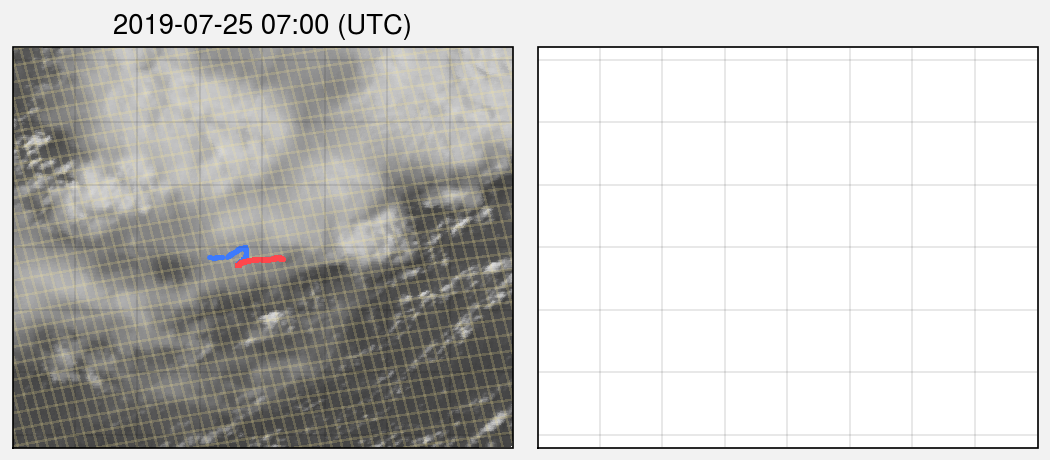

In [11]:
fig, axs = plot.subplots(proj='pcarree', ncols=2, spany=3, sharey=3)

axs.format(lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),)

# plot 20190725 data
ax = axs[0]
plot_img(lat_fy4a, lon_fy4a, img, ax)
plot_swath(lat_s5p, lon_s5p, lat_bnd, lon_bnd, crf, ax)
plot_sonde(df_1, 'preconv', ax)
plot_sonde(df_2, 'postconv', ax)
ax.format(title='2019-07-25 07:00 (UTC)')

## Load 20200901 data

In [12]:
lat_s5p, lon_s5p, lat_bnd, lon_bnd, crf, t = load_s5p(f_s5p_2)
lat_fy4a, lon_fy4a, img = load_fy4a(f_fy4a_2, extend)
df_3 = pd.read_csv(sonde_3)
df_4 = pd.read_csv(sonde_4)

Failed to load coordinates for 'DataID(name='latitude', modifiers=())'
Failed to load coordinates for 'DataID(name='longitude', modifiers=())'
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb


## Plot 20200901 data

In [13]:
ax = axs[1]
plot_img(lat_fy4a, lon_fy4a, img, ax)
plot_swath(lat_s5p, lon_s5p, lat_bnd, lon_bnd, crf, ax)
s_prev = plot_sonde(df_3, 'preconv', ax)
s_post = plot_sonde(df_4, 'postconv', ax)
ax.format(title='2020-09-01 06:40 (UTC)')

TROPOMI passing time: 2020-09-01 05:46:00.804882432+00:00


## Plot station

In [14]:
# plot station
axs.scatter(118.9, 31.93,
            marker='*', c='w', s=5,
            transform=ccrs.PlateCarree())

(<matplotlib.collections.PathCollection at 0x7f4e68190130>,
 <matplotlib.collections.PathCollection at 0x7f4e6814c160>)

## Format axis

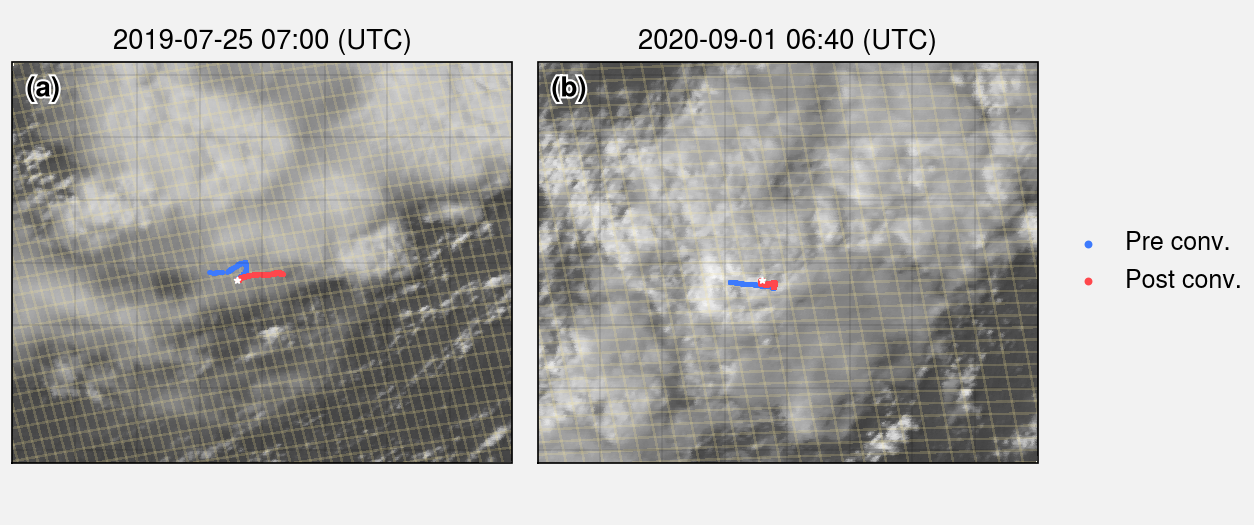

In [15]:
axs.format(abc=True,
           abcloc='ul',
           abcstyle='(a)',
           labels=True,
           lonlines=lon_d,
           latlines=lat_d,
           lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),
           gridlinewidth=0.5,
           gridcolor='w',
           gridlabelcolor='k')

axs[1].format(latlabels=False)
fig.legend([s_prev, s_post], loc='r', ncols=1, frame=False, markerscale=2)

fig.savefig('../figures/overview.png')
fig